## Feature Engineering

In [75]:
# Load the datasets amd load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as pdr

import warnings
warnings.filterwarnings('ignore')

data_path = '../Findata/data.h5'


### Read the data

In [76]:
# set start date and end date
start_year = '1990'
end_year = '2000'

# read dataset
with pd.HDFStore(data_path) as store:
    
    # get stock prices 
    stocks_prices = (store['quandl/wiki/prices']
                    .loc[pd.IndexSlice[str(start_year):str(end_year), :], 'adj_close'])
    
    # unstack ticker to get ticker as columns and date as index
    stocks_prices = stocks_prices.unstack('ticker')

    # get metadata
    stocks_meta = store['us_equities/stocks'].loc[:,['marketcap', 'ipoyear', 'sector']]

    # get common stocks between stock prices and metadata
    common = stocks_prices.columns.intersection(stocks_meta.index)
    
    # get prices and meta data for common stocks
    stocks_meta = stocks_meta.loc[common]
    stocks_prices= stocks_prices[stocks_meta.index]


### Get returns for different lags

In [77]:
# change the frequency to monthly taking the last price for each month
stocks_prices_monthly = stocks_prices.resample('M').last()

# get monthly to yearly returns
lags = [1,3,6,9,12]

monthly_stats = pd.DataFrame()
outlier_cutoff = 0.01
for lag in lags:
    monthly_stats['return_'+str(lag)] = (stocks_prices_monthly
                .pct_change(lag).stack() # get returns for each lag and stack multiindex with (date,ticker)
                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff))) # clip the outliers
                .add(1) # add one and take geometric mean
                .pow(1/lag)
                .sub(1) # subtract one to get returns

    )

# swap date level with ticker level
monthly_stats = monthly_stats.swaplevel().dropna()


In [78]:
monthly_stats


,,return_1,return_3,return_6,return_9,return_12
ticker,date,,,,,
AAN,1991-01-31,0.055180,0.018065,-0.002294,-0.009924,-0.001148
AAPL,1991-01-31,0.290698,0.218923,0.048666,0.039921,0.042760
ABM,1991-01-31,0.176087,0.022162,-0.031103,-0.022674,-0.006170
ABT,1991-01-31,-0.028305,0.021691,0.001734,0.031638,0.026434
ACI,1991-01-31,-0.168714,-0.034951,-0.033892,0.006642,0.018974
...,...,...,...,...,...,...
TDY,2000-12-31,0.227013,-0.067398,0.038037,0.027519,0.079425
ATI,2000-12-31,-0.201207,-0.039999,-0.017547,-0.022649,-0.023501
NKSH,2000-12-31,-0.083333,-0.004080,0.004112,-0.009356,-0.010746


In [79]:
# get stocks with minimum 5 yrs of returns

min_obs = 60
# get number of obs by grouping by ticker
nobs = monthly_stats.groupby(level='ticker').size()

# get ticker to keep
ticker_keep = nobs[nobs>min_obs].index


monthly_stats = monthly_stats.loc[ticker_keep, :]
monthly_stats.head()

return_1  return_3  return_6  return_9  return_12
ticker date                                                         
AAN    1991-01-31  0.055180  0.018065 -0.002294 -0.009924  -0.001148
       1991-02-28  0.040555  0.036730  0.039004 -0.001358   0.003318
       1991-03-31 -0.025641  0.022752  0.021331 -0.004236  -0.017557
       1991-04-30 -0.157895 -0.051326 -0.017243 -0.018913  -0.020441
       1991-05-31  0.015000 -0.059157 -0.012377  0.005195  -0.016133

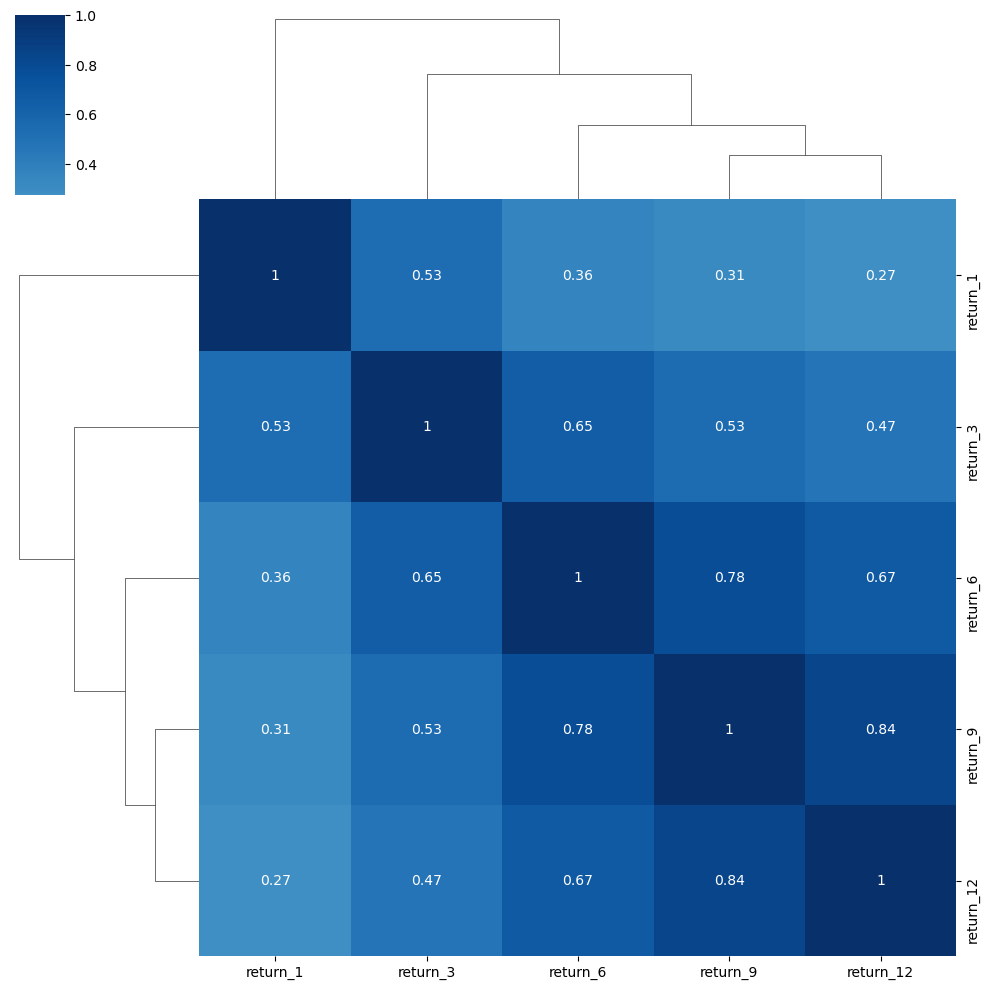

In [80]:

# get clustermap 

sns.clustermap(monthly_stats.corr('spearman'), annot=True, center=0, cmap='Blues');


### FEMA Factors

Fama and French found that value stocks outperform growth stocks. Similarly, small-cap stocks tend to outperform large-cap stocks. As an evaluation tool, the performance of portfolios with a large number of small-cap or value stocks would be lower than the CAPM result


$R_{it} — R_{Ft} = a_i + b_i(R_{Mt} — R_{Ft}) + s_i SMB_t + h_i HML_t + r_i RMW_t + c_i CMA_t + e_it$

The five factors used:

- $R_{ft}$ is the return in month t of one of the portfolios
- $R_{Ft}$ is the riskfree rate
- small minus big (SMB): accounts for publicly traded companies with small market caps that generate higher returns.
- high minus low (HML): accounts for value stocks with high book-to-market ratios that generate higher returns
- robust minus weak (RMW) is the return spread of the most profitable firms minus the least profitable
- conservative minus aggressive (CMA) is the return spread of firms that invest conservatively minus aggressively (AQR, 2014)


A discussion on their performance can be found [Fama and French: The Five-Factor Model Revisited](https://blogs.cfainstitute.org/investor/2022/01/10/fama-and-french-the-five-factor-model-revisited/)




In [81]:
# download the data 

fema = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
fema_data = pdr.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='1990')[0].drop('RF', axis=1)

# make index DatetimeIndex to sample Monthly
fema_data.index = fema_data.index.to_timestamp()
fema_data = fema_data.resample('M').last().div(100)
fema_data.index.name = 'date'

fema_data.head()

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
1990-01-31,-0.0785,-0.0131,0.0085,-0.0117,0.0135
1990-02-28,0.0111,0.0117,0.0064,-0.0003,-0.0066
1990-03-31,0.0183,0.0162,-0.0292,0.0204,-0.0102
1990-04-30,-0.0336,-0.0033,-0.0259,0.0178,-0.0098
1990-05-31,0.0842,-0.0235,-0.0383,0.0157,-0.0168


In [82]:
# join the data with monthly_stats frame

fema_data = fema_data.join(monthly_stats['return_1'])

fema_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 89900 entries, ('AAN', Timestamp('1991-01-31 00:00:00')) to ('ZION', Timestamp('2000-12-31 00:00:00'))
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Mkt-RF    89900 non-null  float64
 1   SMB       89900 non-null  float64
 2   HML       89900 non-null  float64
 3   RMW       89900 non-null  float64
 4   CMA       89900 non-null  float64
 5   return_1  89900 non-null  float64
dtypes: float64(6)
memory usage: 4.5+ MB


### Rolling beta


In simple linear regression, the model is often represented as:

$ Y = \beta_0 + \beta_1 \cdot X + \varepsilon $

where:
- $ Y $ is the dependent variable,
- $ X $ is the independent variable,
- $ \beta_0 $ is the intercept,
- $ \beta_1 $ is the slope,
- $ \varepsilon $ is the error term.

endog: The dependent variable or the "Y" variable in the regression model. The `add_constant` function adds a column of ones to the independent variable, effectively incorporating the intercept term into the regression. So, the line `exog=sm.add_constant(df['X'])` ensures that the OLS model includes an intercept term in addition to the independent variable `X`. This is important for obtaining accurate and interpretable regression coefficients. the **window** is the size of the rolling window, i.e., the number of observations used for each OLS regression. It determines how many data points are considered at a time.


In [83]:
# use linear regression to get rolling beta

from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

# window length 2 yrs
T=24

beta = (fema_data.groupby(level='ticker', group_keys=False) # group by ticker
         .apply(lambda x: RollingOLS(endog=x.return_1,
                                     exog=sm.add_constant(x.drop('return_1', axis=1)),
                                     window=min(T, x.shape[0]-1))
        .fit(params_only=True)  # fit the model 
        .params # get only the params
        .drop('const', axis=1))) # drop constant column as we only need slope



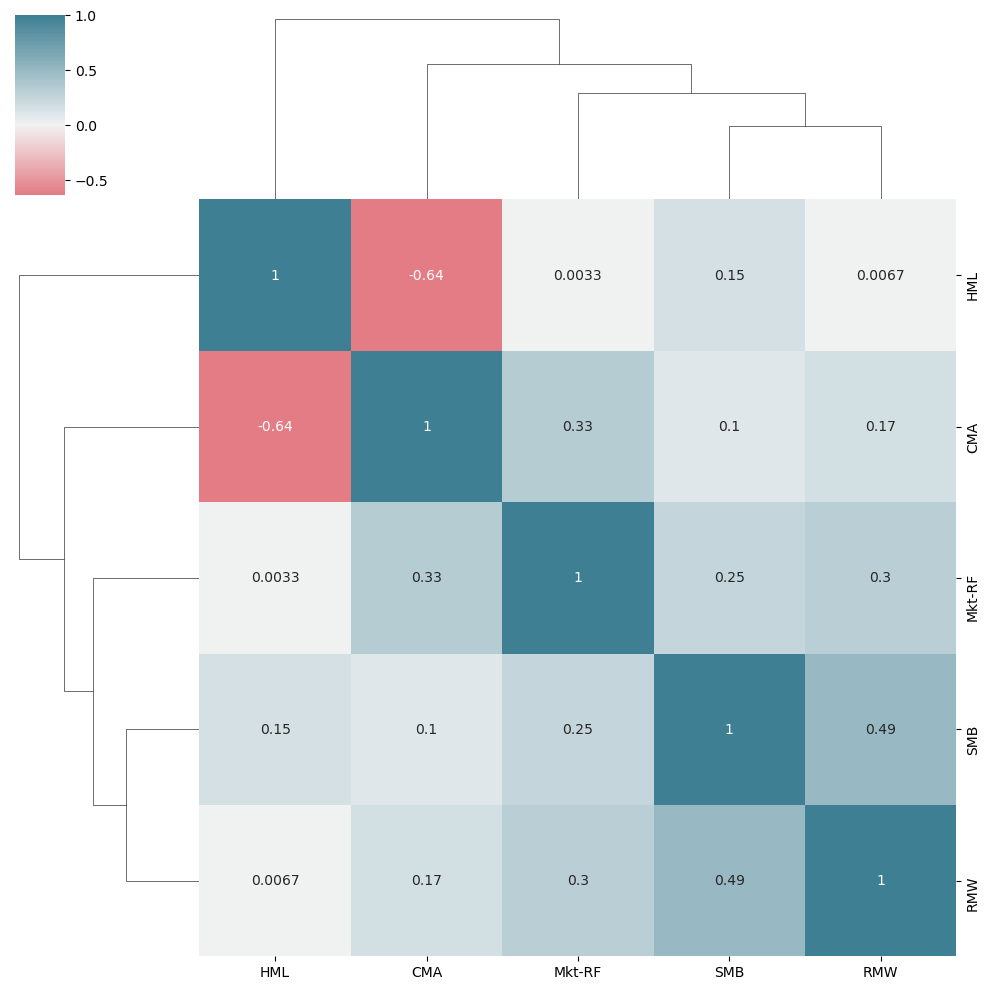

In [84]:
# get correlations of beta for parameters

cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(beta.corr(), annot=True, cmap=cmap, center=0);


### Join Beta with stock data



In [85]:
monthly_stats = monthly_stats.join(beta.groupby(level='ticker').shift())

In [86]:
monthly_stats

return_1  return_3  return_6  return_9  return_12  \
ticker date                                                            
AAN    1991-01-31  0.055180  0.018065 -0.002294 -0.009924  -0.001148   
       1991-02-28  0.040555  0.036730  0.039004 -0.001358   0.003318   
       1991-03-31 -0.025641  0.022752  0.021331 -0.004236  -0.017557   
       1991-04-30 -0.157895 -0.051326 -0.017243 -0.018913  -0.020441   
       1991-05-31  0.015000 -0.059157 -0.012377  0.005195  -0.016133   
...                     ...       ...       ...       ...        ...   
ZION   2000-08-31  0.027415 -0.008103 -0.026484 -0.038379  -0.007173   
       2000-09-30  0.142793  0.038304  0.036488 -0.014548  -0.005057   
       2000-10-31  0.123191  0.096619  0.057303 -0.002188  -0.000957   
       2000-11-30 -0.045466  0.070051  0.030233  0.004685  -0.012348   
       2000-12-31  0.142962  0.070103  0.054084  0.047574   0.005965   

                     Mkt-RF       SMB       HML       RMW       CMA  
ticker date                                                          
AAN    1991-01-31       NaN       NaN       NaN       NaN       NaN  
       1991-02-28       NaN       NaN       NaN       NaN       NaN  
       1991-03-31       NaN       NaN       NaN       NaN       NaN  
       1991-04-30       NaN       NaN       NaN       NaN       NaN  
       1991-05-31       NaN       NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...       ...  
ZION   2000-08-31  1.351552 -0.255507 -1.959683  0.934512  2.597129  
       2000-09-30  0.485832 -0.477130 -2.312226  0.955909  2.183697  
       2000-10-31  0.419296 -0.369956 -1.823394  0.768183  2.202583  
       2000-11-30 -0.258119 -0.200112 -1.220066  0.546780  1.097641  
       2000-12-31 -0.064578 -0.312812 -1.347767  0.479421  1.240593  

[89900 rows x 10 columns]

In [91]:
# fill nan with mean values

monthly_stats.loc[:,fema] = monthly_stats.groupby('ticker')[fema].apply(lambda x: x.fillna(x.mean())).reset_index(0)

monthly_stats

return_1  return_3  return_6  return_9  return_12  \
ticker date                                                            
AAN    1991-01-31  0.055180  0.018065 -0.002294 -0.009924  -0.001148   
       1991-02-28  0.040555  0.036730  0.039004 -0.001358   0.003318   
       1991-03-31 -0.025641  0.022752  0.021331 -0.004236  -0.017557   
       1991-04-30 -0.157895 -0.051326 -0.017243 -0.018913  -0.020441   
       1991-05-31  0.015000 -0.059157 -0.012377  0.005195  -0.016133   
...                     ...       ...       ...       ...        ...   
ZION   2000-08-31  0.027415 -0.008103 -0.026484 -0.038379  -0.007173   
       2000-09-30  0.142793  0.038304  0.036488 -0.014548  -0.005057   
       2000-10-31  0.123191  0.096619  0.057303 -0.002188  -0.000957   
       2000-11-30 -0.045466  0.070051  0.030233  0.004685  -0.012348   
       2000-12-31  0.142962  0.070103  0.054084  0.047574   0.005965   

                     Mkt-RF       SMB       HML       RMW       CMA  
ticker date                                                          
AAN    1991-01-31  0.918433  1.041615  0.998635  0.697569 -0.768793  
       1991-02-28  0.918433  1.041615  0.998635  0.697569 -0.768793  
       1991-03-31  0.918433  1.041615  0.998635  0.697569 -0.768793  
       1991-04-30  0.918433  1.041615  0.998635  0.697569 -0.768793  
       1991-05-31  0.918433  1.041615  0.998635  0.697569 -0.768793  
...                     ...       ...       ...       ...       ...  
ZION   2000-08-31  1.351552 -0.255507 -1.959683  0.934512  2.597129  
       2000-09-30  0.485832 -0.477130 -2.312226  0.955909  2.183697  
       2000-10-31  0.419296 -0.369956 -1.823394  0.768183  2.202583  
       2000-11-30 -0.258119 -0.200112 -1.220066  0.546780  1.097641  
       2000-12-31 -0.064578 -0.312812 -1.347767  0.479421  1.240593  

[89900 rows x 10 columns]